# Deploy and monitor a machine learning workflow for Image Classification

## Setting up this notebook

Notes about the instance size and kernel setup: this notebook has been tested on

1. The `Python 3 (Data Science)` kernel
2. The `ml.t3.medium` Sagemaker notebook instance

## Data Staging

We'll use a sample dataset called CIFAR to simulate the challenges Scones Unlimited are facing in Image Classification. In order to start working with CIFAR we'll need to:

1. Extract the data from a hosting service
2. Transform it into a usable shape and format
3. Load it into a production system

In other words, we're going to do some simple ETL!

### 1. Extract the data from the hosting service

In the cell below, define a function `extract_cifar_data` that extracts python version of the CIFAR-100 dataset. The CIFAR dataaset is open source and generously hosted by the University of Toronto at: https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz 

In [2]:
import requests

def extract_cifar_data(url, filename="cifar.tar.gz"):
    """A function for extracting the CIFAR-100 dataset and storing it as a gzipped file
    
    Arguments:
    url      -- the URL where the dataset is hosted
    filename -- the full path where the dataset will be written
    
    """
    
    # Todo: request the data from the data url
    # Hint: use `requests.get` method
    r = requests.get(url)
    with open(filename, "wb") as file_context:
        file_context.write(r.content)
    return

Let's test it out! Run the following cell and check whether a new file `cifar.tar.gz` is created in the file explorer.

In [3]:
extract_cifar_data("https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz")     

### 2. Transform the data into a usable shape and format

Clearly, distributing the data as a gzipped archive makes sense for the hosting service! It saves on bandwidth, storage, and it's a widely-used archive format. In fact, it's so widely used that the Python community ships a utility for working with them, `tarfile`, as part of its Standard Library. Execute the following cell to decompress your extracted dataset:

In [4]:
import tarfile

with tarfile.open("cifar.tar.gz", "r:gz") as tar:
    tar.extractall()

A new folder `cifar-100-python` should be created, containing `meta`, `test`, and `train` files. These files are `pickles` and the [CIFAR homepage](https://www.cs.toronto.edu/~kriz/cifar.html) provides a simple script that can be used to load them. We've adapted the script below for you to run:

In [5]:
import pickle

with open("./cifar-100-python/meta", "rb") as f:
    dataset_meta = pickle.load(f, encoding='bytes')

with open("./cifar-100-python/test", "rb") as f:
    dataset_test = pickle.load(f, encoding='bytes')

with open("./cifar-100-python/train", "rb") as f:
    dataset_train = pickle.load(f, encoding='bytes')

In [6]:
# Feel free to explore the datasets

dataset_train.keys()

dict_keys([b'filenames', b'batch_label', b'fine_labels', b'coarse_labels', b'data'])

As documented on the homepage, `b'data'` contains rows of 3073 unsigned integers, representing three channels (red, green, and blue) for one 32x32 pixel image per row.

In [7]:
32*32*3

3072

For a simple gut-check, let's transform one of our images. Each 1024 items in a row is a channel (red, green, then blue). Each 32 items in the channel are a row in the 32x32 image. Using python, we can stack these channels into a 32x32x3 array, and save it as a PNG file:

In [8]:
import numpy as np

# Each 1024 in a row is a channel (red, green, then blue)
row = dataset_train[b'data'][0]
red, green, blue = row[0:1024], row[1024:2048], row[2048:]

# Each 32 items in the channel are a row in the 32x32 image
red = red.reshape(32,32)
green = green.reshape(32,32)
blue = blue.reshape(32,32)

# Combine the channels into a 32x32x3 image!
combined = np.dstack((red,green,blue))

For a more concise version, consider the following:

In [9]:
# All in one:
test_image = np.dstack((
    row[0:1024].reshape(32,32),
    row[1024:2048].reshape(32,32),
    row[2048:].reshape(32,32)
))

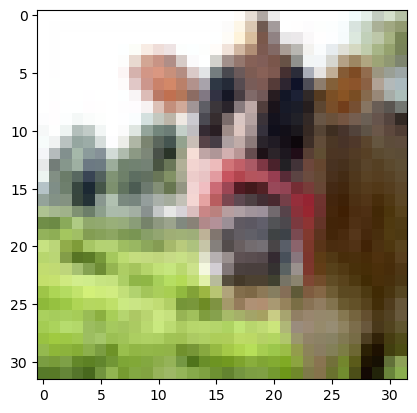

In [10]:
import matplotlib.pyplot as plt
plt.imshow(test_image);

Looks like a cow! Let's check the label. `dataset_meta` contains label names in order, and `dataset_train` has a list of labels for each row.

In [11]:
dataset_train[b'fine_labels'][0]

19

Our image has a label of `19`, so let's see what the 19th item is in the list of label names.

In [12]:
print(dataset_meta[b'fine_label_names'][19])

b'cattle'


Ok! 'cattle' sounds about right. By the way, using the previous two lines we can do:

In [13]:
n = 0
print(dataset_meta[b'fine_label_names'][dataset_train[b'fine_labels'][n]])

b'cattle'


Now we know how to check labels, is there a way that we can also check file names? `dataset_train` also contains a `b'filenames'` key. Let's see what we have here:

In [14]:
print(dataset_train[b'filenames'][0])

b'bos_taurus_s_000507.png'


"Taurus" is the name of a subspecies of cattle, so this looks like a pretty reasonable filename. To save an image we can also do:

In [15]:
plt.imsave("file.png", test_image)

Your new PNG file should now appear in the file explorer -- go ahead and pop it open to see!

Now that you know how to reshape the images, save them as files, and capture their filenames and labels, let's just capture all the bicycles and motorcycles and save them. Scones Unlimited can use a model that tells these apart to route delivery drivers automatically.

In the following cell, identify the label numbers for Bicycles and Motorcycles:

In [16]:
# Todo: Filter the dataset_train and dataset_meta objects to find the label numbers for Bicycle and Motorcycles
import pandas as pd

# Assuming dataset_meta and dataset_train have been loaded as per previous instructions

# Convert byte keys to strings for easier access
label_names = [name.decode('utf-8') for name in dataset_meta[b'fine_label_names']]

# Create a DataFrame to easily filter labels
labels_df = pd.DataFrame({
    'label_name': label_names,
    'label_id': range(len(label_names))
})

# Filter for Bicycle and Motorcycles
bicycle_label = labels_df[labels_df['label_name'] == 'bicycle']
motorcycle_label = labels_df[labels_df['label_name'] == 'motorcycle']

# Extracting the label numbers
bicycle_label_number = bicycle_label['label_id'].values[0] if not bicycle_label.empty else None
motorcycle_label_number = motorcycle_label['label_id'].values[0] if not motorcycle_label.empty else None

print(f"Bicycle Label Number: {bicycle_label_number}")
print(f"Motorcycle Label Number: {motorcycle_label_number}")




Bicycle Label Number: 8
Motorcycle Label Number: 48


Good job! We only need objects with label 8 and 48 -- this drastically simplifies our handling of the data! Below we construct a dataframe for you, and you can safely drop the rows that don't contain observations about bicycles and motorcycles. Fill in the missing lines below to drop all other rows:

In [17]:
import pandas as pd

# Construct the dataframe for training data
df_train = pd.DataFrame({
    "filenames": dataset_train[b'filenames'],
    "labels": dataset_train[b'fine_labels'],
    "row": range(len(dataset_train[b'filenames']))
})

# Drop all rows from df_train where label is not 8 or 48
df_train = df_train[df_train["labels"].isin([8, 48])]

# Decode df_train.filenames so they are regular strings
df_train["filenames"] = df_train["filenames"].apply(
    lambda x: x.decode("utf-8")
)

# Construct the dataframe for test data
df_test = pd.DataFrame({
    "filenames": dataset_test[b'filenames'],
    "labels": dataset_test[b'fine_labels'],
    "row": range(len(dataset_test[b'filenames']))
})

# Drop all rows from df_test where label is not 8 or 48
df_test = df_test[df_test["labels"].isin([8, 48])]

# Decode df_test.filenames so they are regular strings
df_test["filenames"] = df_test["filenames"].apply(
    lambda x: x.decode("utf-8")
)

Now that the data is filtered for just our classes, we can save all our images.

In [18]:
!mkdir ./train
!mkdir ./test

In the previous sections we introduced you to several key snippets of code:

1. Grabbing the image data:

```python
dataset_train[b'data'][0]
```

2. A simple idiom for stacking the image data into the right shape

```python
import numpy as np
np.dstack((
    row[0:1024].reshape(32,32),
    row[1024:2048].reshape(32,32),
    row[2048:].reshape(32,32)
))
```

3. A simple `matplotlib` utility for saving images

```python
plt.imsave(path+row['filenames'], target)
```

Compose these together into a function that saves all the images into the `./test` and `./train` directories. Use the comments in the body of the `save_images` function below to guide your construction of the function:


In [20]:
import os
import numpy as np
import matplotlib.pyplot as plt

def save_images(df, directory):
    """
    Save images from a DataFrame to a specified directory.

    Arguments:
    df -- DataFrame containing filenames and image labels
    directory -- Directory where images will be saved
    """
    for index, row in df.iterrows():
        # Grab the image data in row-major form
        img = dataset_train[b'data'][row['row']] if directory == './train' else dataset_test[b'data'][row['row']]
        
        # Consolidated stacking/reshaping from earlier
        target = np.dstack((
            img[0:1024].reshape(32, 32),
            img[1024:2048].reshape(32, 32),
            img[2048:].reshape(32, 32)
        ))
        
        # Save the image
        plt.imsave(os.path.join(directory, row['filenames']), target)
    
    # Return a signal indicating completion for debugging
    return f"Saved {len(df)} images to {directory}"

In [21]:
train_signal = save_images(df_train, './train')
test_signal = save_images(df_test, './test')

print(train_signal)
print(test_signal)

Saved 1000 images to ./train
Saved 200 images to ./test


### 3. Load the data

Now we can load the data into S3.

Using the sagemaker SDK grab the current region, execution role, and bucket.

In [22]:
import sagemaker

# Grab the current region
region = sagemaker.Session().boto_region_name

# Grab the execution role
role = sagemaker.get_execution_role()

# Grab the default bucket
bucket = sagemaker.Session().default_bucket()

print("Default Bucket: {}".format(bucket))
print("AWS Region: {}".format(region))
print("RoleArn: {}".format(role))

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
Default Bucket: sagemaker-us-east-1-653035930823
AWS Region: us-east-1
RoleArn: arn:aws:iam::653035930823:role/service-role/AmazonSageMaker-ExecutionRole-20240922T225700


With this data we can easily sync your data up into S3!

In [23]:
import os

os.environ["DEFAULT_S3_BUCKET"] = bucket
!aws s3 sync ./train s3://${DEFAULT_S3_BUCKET}/train/
!aws s3 sync ./test s3://${DEFAULT_S3_BUCKET}/test/

upload: train/bicycle_s_000021.png to s3://sagemaker-us-east-1-653035930823/train/bicycle_s_000021.png
upload: train/bicycle_s_000039.png to s3://sagemaker-us-east-1-653035930823/train/bicycle_s_000039.png
upload: train/bicycle_s_000038.png to s3://sagemaker-us-east-1-653035930823/train/bicycle_s_000038.png
upload: train/bicycle_s_000035.png to s3://sagemaker-us-east-1-653035930823/train/bicycle_s_000035.png
upload: train/bicycle_s_000017.png to s3://sagemaker-us-east-1-653035930823/train/bicycle_s_000017.png
upload: train/bicycle_s_000099.png to s3://sagemaker-us-east-1-653035930823/train/bicycle_s_000099.png
upload: train/bicycle_s_000071.png to s3://sagemaker-us-east-1-653035930823/train/bicycle_s_000071.png
upload: train/bicycle_s_000137.png to s3://sagemaker-us-east-1-653035930823/train/bicycle_s_000137.png
upload: train/bicycle_s_000043.png to s3://sagemaker-us-east-1-653035930823/train/bicycle_s_000043.png
upload: train/bicycle_s_000147.png to s3://sagemaker-us-east-1-6530359308

And that's it! You can check the bucket and verify that the items were uploaded.

## Model Training

For Image Classification, Sagemaker [also expects metadata](https://docs.aws.amazon.com/sagemaker/latest/dg/image-classification.html) e.g. in the form of TSV files with labels and filepaths. We can generate these using our Pandas DataFrames from earlier:

In [24]:
def to_metadata_file(df, prefix):
    df["s3_path"] = df["filenames"]
    df["labels"] = df["labels"].apply(lambda x: 0 if x==8 else 1)
    return df[["row", "labels", "s3_path"]].to_csv(
        f"{prefix}.lst", sep="\t", index=False, header=False
    )
    
to_metadata_file(df_train.copy(), "train")
to_metadata_file(df_test.copy(), "test")

We can also upload our manifest files:

In [25]:
import boto3

# Upload files
boto3.Session().resource('s3').Bucket(
    bucket).Object('train.lst').upload_file('./train.lst')
boto3.Session().resource('s3').Bucket(
    bucket).Object('test.lst').upload_file('./test.lst')

Using the `bucket` and `region` info we can get the latest prebuilt container to run our training job, and define an output location on our s3 bucket for the model. Use the `image_uris` function from the SageMaker SDK to retrieve the latest `image-classification` image below:

In [26]:
from sagemaker import image_uris

# Use the image_uris function to retrieve the latest 'image-classification' image
algo_image = image_uris.retrieve(framework='image-classification', region=region)

# Define the output location for the model
s3_output_location = f"s3://{bucket}/models/image_model"

We're ready to create an estimator! Create an estimator `img_classifier_model` that uses one instance of `ml.p3.2xlarge`. Ensure that y ou use the output location we defined above - we'll be referring to that later!

In [27]:
img_classifier_model=sagemaker.estimator.Estimator(
    ## TODO: define your estimator options   
    image_uri=algo_image,
    role=role,
    instance_count =1,
    instance_type = 'ml.p2.xlarge',
    output_path = s3_output_location,
    sagemaker_session=sagemaker.Session()
    
)

We can also set a few key hyperparameters and define the inputs for our model:

In [28]:
img_classifier_model.set_hyperparameters(
    image_shape='3,32,32', # TODO: Fill in
    num_classes=2, # TODO: Fill in
    num_training_samples= df_train.shape[0],
    early_stopping=True,                     
    early_stopping_min_epochs=10,
    augmentation_type= "crop_color_transform",
)

The `image-classification` image uses four input channels with very specific input parameters. For convenience, we've provided them below:

In [29]:
from sagemaker.debugger import Rule, rule_configs
from sagemaker.session import TrainingInput
model_inputs = {
        "train": sagemaker.inputs.TrainingInput(
            s3_data=f"s3://{bucket}/train/",
            content_type="application/x-image"
        ),
        "validation": sagemaker.inputs.TrainingInput(
            s3_data=f"s3://{bucket}/test/",
            content_type="application/x-image"
        ),
        "train_lst": sagemaker.inputs.TrainingInput(
            s3_data=f"s3://{bucket}/train.lst",
            content_type="application/x-image"
        ),
        "validation_lst": sagemaker.inputs.TrainingInput(
            s3_data=f"s3://{bucket}/test.lst",
            content_type="application/x-image"
        )
}

In [30]:
## TODO: train your model
img_classifier_model.fit(model_inputs)

INFO:sagemaker:Creating training-job with name: image-classification-2024-09-26-02-55-05-058


2024-09-26 02:55:05 Starting - Starting the training job...
2024-09-26 02:55:32 Starting - Preparing the instances for training............
2024-09-26 02:57:08 Downloading - Downloading input data...
2024-09-26 02:58:03 Downloading - Downloading the training image.....................
2024-09-26 03:01:25 Training - Training image download completed. Training in progress......Docker entrypoint called with argument(s): train
Running default environment configuration script
Nvidia gpu devices, drivers and cuda toolkit versions (only available on hosts with GPU):
Thu Sep 26 03:02:08 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.256.02   Driver Version: 470.256.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
| 

Great, now we can train the model using the model_inputs. In the cell below, call the `fit` method on our model,:

If all goes well, you'll end up with a model topping out above `.8` validation accuracy. With only 1000 training samples in the CIFAR dataset, that's pretty good. We could definitely pursue data augmentation & gathering more samples to help us improve further, but for now let's proceed to deploy our model.

### Getting ready to deploy

To begin with, let's configure Model Monitor to track our deployment. We'll define a `DataCaptureConfig` below:

In [33]:
from sagemaker.model_monitor import DataCaptureConfig

# Define the prefix for your S3 path
prefix = "my-image-classifier"  # Customize this according to your use case

# Unique S3 URI where the captured data is stored
capture_uri = f's3://{bucket}/{prefix}/data-capture'

# Set DataCaptureConfig with options
data_capture_config = DataCaptureConfig(
    enable_capture=True,               # Enable Data Capture
    sampling_percentage=100,           # 100: capture all inferences
    destination_s3_uri=capture_uri     # S3 location to store captured data
)

print("DataCaptureConfig set up successfully!")


DataCaptureConfig set up successfully!


Note the `destination_s3_uri` parameter: At the end of the project, we can explore the `data_capture` directory in S3 to find crucial data about the inputs and outputs Model Monitor has observed on our model endpoint over time.

With that done, deploy your model on a single `ml.m5.xlarge` instance with the data capture config attached:

In [34]:
try:
    # Deploy the model with data capture configuration
    deployment = img_classifier_model.deploy(
        initial_instance_count=1, 
        instance_type='ml.m4.xlarge',  # Try ml.m5.xlarge if p3.xlarge causes issues
        data_capture_config=data_capture_config  # Attach data capture configuration
    )

    # Get the endpoint name
    endpoint = deployment.endpoint_name
    print("Endpoint deployed successfully:", endpoint)

except Exception as e:
    print("Error during model deployment:", str(e))

INFO:sagemaker:Creating model with name: image-classification-2024-09-26-03-17-14-658
INFO:sagemaker:Creating endpoint-config with name image-classification-2024-09-26-03-17-14-658
INFO:sagemaker:Creating endpoint with name image-classification-2024-09-26-03-17-14-658


-----------------!Endpoint deployed successfully: image-classification-2024-09-26-03-17-14-658


Note the endpoint name for later as well.

Next, instantiate a Predictor:

In [36]:
from sagemaker.predictor import Predictor

## TODO: fill in
predictor = Predictor(endpoint_name = endpoint) # Make prediction requests to an Amazon SageMaker endpoint.

In the code snippet below we are going to prepare one of your saved images for prediction. Use the predictor to process the `payload`.

In [37]:
from sagemaker.serializers import IdentitySerializer

# Set the serializer for the predictor to handle image/png format
predictor.serializer = IdentitySerializer("image/png")

# Open the image file and read the bytes
with open("./test/bicycle_s_001789.png", "rb") as f:
    payload = f.read()

# Send the payload to the deployed endpoint for inference
inference = predictor.predict(payload)

# Print the result of the inference
print("Inference result:", inference)


Inference result: b'[0.7090908288955688, 0.29090917110443115]'


Your `inference` object is an array of two values, the predicted probability value for each of your classes (bicycle and motorcycle respectively.) So, for example, a value of `b'[0.91, 0.09]'` indicates the probability of being a bike is 91% and being a motorcycle is 9%.

In [38]:
print(inference)

b'[0.7090908288955688, 0.29090917110443115]'


import json
import boto3
import base64

def lambda_handler(event, context):
    # Initialize S3 client
    s3_client = boto3.client('s3')
    
    # Extract bucket name and object key from the event
    bucket_name = event['bucket']  # Assuming 'bucket' key contains the bucket name
    object_key = event['key']       # Assuming 'key' key contains the object key (file name)

    try:
        # Get the object from S3
        s3_response = s3_client.get_object(Bucket=bucket_name, Key=object_key)
        
        # Read the image data from the response
        image_data = s3_response['Body'].read()

        # Encode the image data to base64
        encoded_image_data = base64.b64encode(image_data).decode('utf-8')

        # Return serialized data as part of the response
        return {
            'statusCode': 200,
            'body': json.dumps({
                'image_data': encoded_image_data
            })
        }

    except Exception as e:
        print(f"Error processing object {object_key} from bucket {bucket_name}. Error: {str(e)}")
        return {
            'statusCode': 500,
            'body': json.dumps({
                'error': str(e)
            })
        }



Great! Now you can use the files in `./test` as test files for our workflow. Depending on our threshold, our workflow should reliably pass predictions about images from `./test` on to downstream systems, while erroring out for inferences below our confidence threshold!

### Testing and Evaluation

Do several step function invokations using data from the `./test` folder. This process should give you confidence that the workflow both *succeeds* AND *fails* as expected. In addition, SageMaker Model Monitor will generate recordings of your data and inferences which we can visualize.

Here's a function that can help you generate test inputs for your invokations:

In [41]:
import random
import boto3
import json


def generate_test_case():
    # Setup s3 in boto3
    s3 = boto3.resource('s3')
    
    # Randomly pick from sfn or test folders in our bucket
    objects = s3.Bucket(bucket).objects.filter(Prefix=prefix)
    
    # Grab any random object key from that folder!
    obj = random.choice([x.key for x in objects])
    
    return json.dumps({
        "image_data": "",
        "s3_bucket": bucket,
        "s3_key": obj
    })

generate_test_case()

'{"image_data": "", "s3_bucket": "sagemaker-us-east-1-653035930823", "s3_key": "my-image-classifier/data-capture/image-classification-2024-09-25-19-10-00-973/AllTraffic/2024/09/25/19/20-06-164-4a7cde7c-b370-4b48-a09b-7f7672dd87af.jsonl"}'

In the Step Function dashboard for your new function, you can create new executions and copy in the generated test cases. Do several executions so that you can generate data you can evaluate and visualize.

Once you've done several executions, let's visualize the record of our inferences. Pull in the JSONLines data from your inferences like so:

In [43]:
from sagemaker.s3 import S3Downloader

# Define your S3 bucket and prefix (the path structure leading to your data capture)
bucket = "sagemaker-us-east-1-653035930823"  # Your S3 bucket name
prefix = "my-image-classifier"  # Your prefix for organization

# Construct the specific data path for the JSONLines file you've indicated
data_path = "s3://sagemaker-us-east-1-653035930823/my-image-classifier/data-capture/image-classification-2024-09-25-19-10-00-973/AllTraffic/2024/09/25/19/20-06-164-4a7cde7c-b370-4b48-a09b-7f7672dd87af.jsonl".format(bucket)

# Download the captured data from S3
S3Downloader.download(data_path,       # s3_uri to download from
                      "captured_data") # A local path to download the file(s) to

# Print a confirmation message
print("Data downloaded to 'captured_data' directory.")


Data downloaded to 'captured_data' directory.


The data are in JSONLines format, where multiple valid JSON objects are stacked on top of eachother in a single `jsonl` file. We'll import an open-source library, `jsonlines` that was purpose built for parsing this format.

In [44]:
!pip install jsonlines
import jsonlines

Now we can extract the data from each of the source files:

In [46]:
import os

# List the file names we downloaded
file_handles = os.listdir("./captured_data")

# Dump all the data into an array
json_data = []
for jsonl in file_handles:
    with jsonlines.open(f"./captured_data/{jsonl}") as f:
        json_data.append(f.read())

The data should now be a list of dictionaries, with significant nesting. We'll give you an example of some code that grabs data out of the objects and visualizes it:

In [47]:
# Define how we'll get our data
def simple_getter(obj):
    inferences = obj["captureData"]["endpointOutput"]["data"]
    timestamp = obj["eventMetadata"]["inferenceTime"]
    return json.loads(inferences), timestamp

simple_getter(json_data[0])

([0.6891490817070007, 0.3108508884906769], '2024-09-25T19:20:06Z')

Finally, here's an example of a visualization you can build with this data. In this last part, you will take some time and build your own - the captured data has the input images, the resulting inferences, and the timestamps.

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


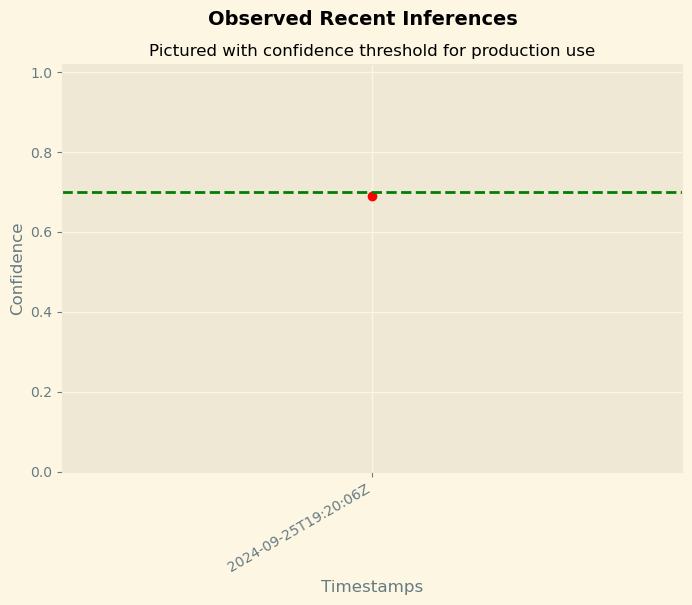

In [49]:
# Populate the data for the x and y axis
%matplotlib inline
THRESHOLD = 0.70
x = []
y = []
for obj in json_data:
    inference, timestamp = simple_getter(obj)
    
    y.append(max(inference))
    x.append(timestamp)

# Todo: here is an visualization example, take some time to build another visual that helps monitor the result
# Plot the data

plt.figure(figsize=(8,6))
plt.scatter(x, y, c=['r' if k<THRESHOLD else 'b' for k in y ])
plt.axhline(y=THRESHOLD, color='g', linestyle='--')
plt.ylim(bottom=0,top=1.02)

# Add labels
plt.ylabel("Confidence")
plt.xlabel("Timestamps")
plt.suptitle("Observed Recent Inferences", size=14, y=0.97, fontweight='bold')
plt.title("Pictured with confidence threshold for production use", size=12)

# Give it some pizzaz!
plt.style.use("Solarize_Light2")
plt.gcf().autofmt_xdate()
plt.show()

### Todo: build your own visualization


In [55]:
# My Simple Getter:
def my_simple_getter(obj):
    inferences = obj["captureData"]["endpointOutput"]["data"]
    timestamp = obj["eventMetadata"]["inferenceTime"]
    images = obj["captureData"]["endpointInput"]["data"]
    return json.loads(inferences), timestamp, images

# Example: first object retrieved
my_simple_getter(json_data[0])

([0.6891490817070007, 0.3108508884906769],
 '2024-09-25T19:20:06Z',
 'iVBORw0KGgoAAAANSUhEUgAAACAAAAAgCAYAAABzenr0AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8fJSN1AAAACXBIWXMAAA9hAAAPYQGoP6dpAAAKm0lEQVR4nE2X6W9cR3ZHT23v9Xu9N8kmqeamhaQsWbJsy4PEyAwmg+TPjoMgQGaRFY93ybYWylyb3eyF/fqtVZUPVIy5HwuFQuGHey/OEZ88vOtLQlY3tzg/P6VIM7KyQkiFsxUS8AK0VHRXunQbPWS9RaO7Rp6XZGWOCQKUkgibU1nwUuOqijIv0MYQRDWU0mRZgfceAVjnkM4jg1qMCmo4qcm9ppA1SidQSlFvtvAqoHSCuNmhs9on7nRpNdpYm5MsZzjvAHDWUZUVnU4HpTTee6SUIATNZpNms/nbmeemBAI5WpRYqWluH9DortLsb+KVurnoPVor6vUGn//+D8goRkQNgkaD4fkpeZaihMRbR5FlSK3QWqKEI6qFxHGMMQYhBM5ZhPA4V6ElBFrhBOjVvX2S+Zh2f4MdY7HWMzo9QghBnudordnZG3Dw8A6vXv3AIiupPORZRlRvIhEoIUBpoqjGdDphdXUNJQ1CKCazGVJKlssl3jvwYMsSqRRI0J3NdSZXZxy9+IaVwTqNZh0pBFJKlFK0Wi2qsmIyHLLS6iBMzGK5IDQKISUI8N6jlCRJEpyzXFxcUOQVzgnCKMR6R1mWKKXAe6y1OGsRUqOFS/A2Yzq6IAwMvu1w3uOlpBE3kEpjS8tyVtJaG2CiJvvdmJ9fvWY2S8FLrPc3KXiP94AQGKPQOiButphfX1NVFfD+s1oDAu9Bzy7PCBRYW3I9mzJfJFjnEMqg4zpCePI8Z56mPH76KZeTKW

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


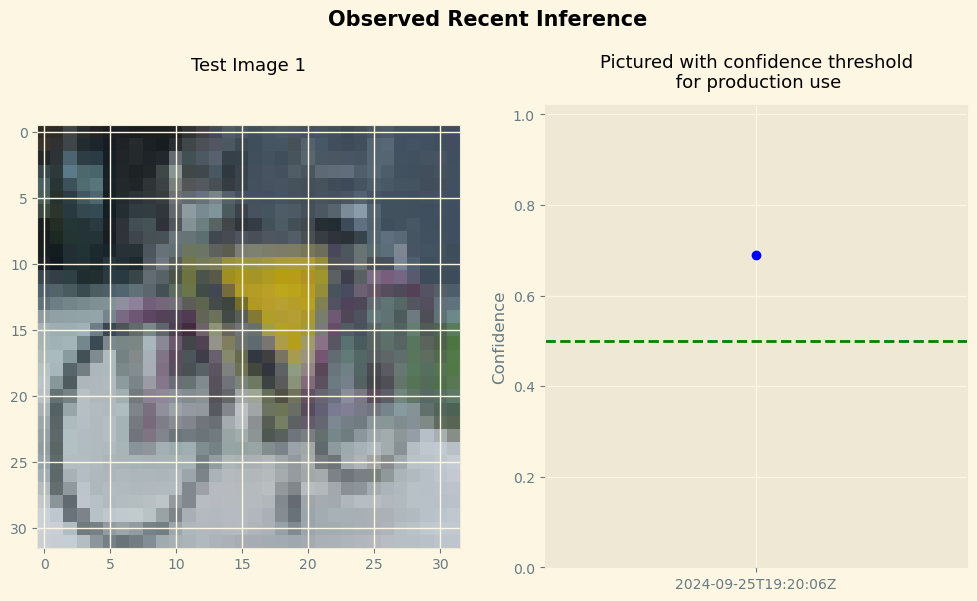

In [56]:
# Required imports
import io
import base64  # Import base64 to decode images
import matplotlib.pyplot as plt
from PIL import Image

# Assuming json_data is your list of inference records and THRESHOLD is defined
THRESHOLD = 0.5  # Define your confidence threshold here

# Visualizing images and their inferences in comparison to the assumed threshold
%matplotlib inline

x = []
y = []
for idx, obj in enumerate(json_data):
    inference, timestamp, image = my_simple_getter(obj)  # Extract inference data
    
    # Decode the base64 encoded image string
    img = base64.b64decode(image)     
    img = io.BytesIO(img) 
    img = Image.open(img)  # Open image
    
    # Plotting subplots to display Images along with their performances
    f = plt.figure(figsize=(12, 6))
    f.suptitle("Observed Recent Inference", size=15, y=1.04, fontweight='bold')
    
    # Plot Test Image
    ax1 = f.add_subplot(121)
    ax1.set_title(f"Test Image {idx + 1}", size=13, y=1.11)
    ax1.imshow(img, interpolation='nearest')
    
    # Plot Inference and Time Data
    ax2 = f.add_subplot(122)
    ax2.scatter(timestamp, max(inference), c=['r' if max(inference) < THRESHOLD else 'b'])
    ax2.axhline(y=THRESHOLD, color='g', linestyle='--')
    ax2.set_ylim(bottom=0, top=1.02)
    
    # Add labels
    ax2.set_ylabel("Confidence")
    ax2.set_title("Pictured with confidence threshold\n for production use", size=13, y=1.02)
    
    plt.show()


### Congratulations!

You've reached the end of the project. In this project you created an event-drivent ML workflow that can be incorporated into the Scones Unlimited production architecture. You used the SageMaker Estimator API to deploy your SageMaker Model and Endpoint, and you used AWS Lambda and Step Functions to orchestrate your ML workflow. Using SageMaker Model Monitor, you instrumented and observed your Endpoint, and at the end of the project you built a visualization to help stakeholders understand the performance of the Endpoint over time. If you're up for it, you can even go further with these stretch goals:

* Extend your workflow to incorporate more classes: the CIFAR dataset includes other vehicles that Scones Unlimited can identify with this model.
* Modify your event driven workflow: can you rewrite your Lambda functions so that the workflow can process multiple image inputs in parallel? Can the Step Function "fan out" to accomodate this new workflow?
* Consider the test data generator we provided for you. Can we use it to create a "dummy data" generator, to simulate a continuous stream of input data? Or a big paralell load of data?
* What if we want to get notified every time our step function errors out? Can we use the Step Functions visual editor in conjunction with a service like SNS to accomplish this? Try it out!


